# Training and testing with AI library flake analysis
* I tried to train and test flake analysis with the RHV dataset. I couldn't make sense of the results so I tried to deconstruct the code (remove engineering parts). In this notebook, I try to understand how flake analysis model is trained and understand the obtained results.
* I bring all the code from extract.py, cluster.py, and ncd.py which makes this notebook bulky, but it's important in terms of debugging the code efficiently.
* I don't bring in data.py because it is just engineering around data formats.
* [AI Library code reference](https://gitlab.com/opendatahub/ai-library/-/tree/master/flakes_train/bots/learn)

In [2]:
import warnings
import os
import sys
import inspect
warnings.filterwarnings("ignore")
import boto3
import json
import tempfile
import gzip, pickle
import datetime
import time
import csv
import io
import uuid
import argparse
import subprocess
import zipfile
import json
import re
import operator
import random
import tempfile
import sklearn.cluster
import sklearn.neighbors
import numpy
import zlib
import configparser
import random
import pandas as pd

## extractor.py
* This module is supposed to extract features from the text log

In [3]:
VERSION = 3
# This code extracts features from log items. In particular it normalizes
# and exracts the log.
#
# TODO: We could weight log lines using TF-IDF, but that would require
# a distance function that could apply that weight between lines. The
# NCD distance we use cannot do that.

import calendar
import re
import time

import sklearn.feature_extraction.text

# Ignore lines that appear in at least this fraction of logs
IGNORE_THRESHHOLD = 0.6

# Choose only one out of every N tracked items. These have
# already been manually "clustered" elsewhere, and we only need
# some cluster seeds
TRACKER_SPARSE = 100

# TODO: We should be able to detect these automatically and ignore them
# But for now this is a pragmatic hack to reduce noise and processing time
NOISE = {
    "Wrote file": re.compile("Wrote.*\.(png|html|log)"),
    "Journal extracted": re.compile("Journal extracted to.*\.log"),
    "Core dumps downloaded": re.compile("Core dumps downloaded to.*\.core"),
    "not ok": re.compile("^not ok.*"),
    "ok": re.compile("^ok.*"),
    "# Flake": re.compile("# Flake.*"),
    'File "\\1"': re.compile('File "/[^"]+/([^/]+)"'),
    "### ": re.compile('#{3,80}\s+'),
}

DIGITS = re.compile('\d+')

# Various features extracted
FEATURE_LOG = 0                # string: The normalized and collapsed log extracted
FEATURE_INDEX = 1              # number: Unique index of the item
FEATURE_URL = 2                # string: The full URL to the test result
FEATURE_NAME = 3               # string: The name of the test run
FEATURE_CONTEXT = 4            # string: The context in which the test is run
FEATURE_TRACKER = 5            # string: A tracker issue for this
FEATURE_MERGED = 6             # number: 1 if merged, 0 if not, -1 if unknown
FEATURE_TIMESTAMP = 7          # number: The time since epoch at which test was run

# Return already tokenized data
def noop(value):
    return value

# Select which items we want to operate on.
#
# Because we have so many tracked failures, we need to only bring
# some of those into our clustering algorithm. We can assume that
# these are already clusters
tracked = { }
def select(item):
    if item.get("status") != "FAILED":
        return False
    tracker = item.get("tracker")
    if not tracker:
        return True
    count = tracked[tracker] = tracked.get(tracker, 0) + 1
    return count % TRACKER_SPARSE == 0 # Only every Nth for tracked failures

# The actual feature extractor. Currently only extracts a
# normalized log from each item. By using fit() you can train
# the extractor to ignore frequently found lines.
class Extractor():
    def __init__(self, verbose=False):
        self.extract = sklearn.feature_extraction.text.CountVectorizer(
            analyzer='word',
            tokenizer=noop,
            lowercase=False,
            max_df=IGNORE_THRESHHOLD)
        self.verbose = verbose

    @staticmethod
    def tokenize(item):
        result = [ ]
        value = item["log"] or ""
        for line in value.replace('\r\n', '\n').replace('\r', '\n').split('\n'):
            line = line.strip()
            for substitute, pattern in NOISE.items():
                line = pattern.sub(substitute, line)
            else:
                result.append(DIGITS.sub('000', line))
        return result

    def fit(self, items, tokenized=None):
        tokenized = tokenized or map(Extractor.tokenize, items)
        self.extract.fit(tokenized)

    def transform(self, items, tokenized=None):
        tokenized = list(tokenized or map(Extractor.tokenize, items))
        results = [ ]
        for index, item in enumerate(items):
            if not select(item):
                continue
            lines = tokenized[index]
            filtered = filter(lambda line: line not in self.extract.stop_words_, lines)
#             try:
#                 timestamp = calendar.timegm(time.strptime(item.get("date", ""), "%Y-%m-%dT%H:%M:%SZ"))
#             except ValueError:
            timestamp = -1
            merged = item.get("merged")
            if merged is None:
                merged = -1
            else:
                merged = merged and 1 or 0
            results.append((
                "\n".join(filtered),      # FEATURE_LOG
                index,                    # FEATURE_INDEX
                item.get("url", ""),      # FEATURE_URL
                item.get("test", ""),     # FEATURE_NAME
                item.get("context", ""),  # FEATURE_CONTEXT
                item.get("tracker", ""),  # FEATURE_TRACKER
                merged,                   # FEATURE_MERGED
                timestamp                 # FEATURE_TIMESTAMP
            ))
        return results

    def fit_transform(self, items):
        tokenized = list(map(Extractor.tokenize, items))
        self.fit(items, tokenized)
        return self.transform(items, tokenized)

    def stop_tokens(self):
        return self.extract.stop_words_

## ncd.py
* This is the part where the log text is encoded into a compressed version and the distance between them is computed using a normalized compressed distance

In [4]:
def K(val):
    result = len(zlib.compress(val.encode('utf-8'), 6))
    return float(result)

# We use a cache to accelelerate NCD calculations and avoid
# same of the re-compression of identical data
cache = { }
vectors = [ ]

def calculate(a, b):
    # Zero distance between identical pairs
    if a == b:
        return 0
    # Compression length for individual parts are cached
    Ka = cache.get(a)
    if Ka is None:
        Ka = K(a)
    Kb = cache.get(b)
    if Kb is None:
        Kb = K(b)
    # The compression distance for combined
    Kab = K(a + b)
    return (Kab - min(Ka, Kb)) / max(Ka, Kb)

# Precompute all individual hashes to cache and convert to vector array
def prepare(values):
    global vectors, cache
    values = list(values)
    array = numpy.zeros((len(values), 1))
    for i, value in enumerate(values):
        index = len(vectors)
        array[i][0] = index
        vectors.append(value)
        cache[value] = K(value)
    return array

# A function usable as a metric in scikit-learn
# Make sure to call prepare() first on the actual values
def metric(x, y):
    global vectors
    i, j = int(x[0]), int(y[0])
    return calculate(vectors[i], vectors[j])

# Cluster.py
## Relevant parts of class Cluster
* The cluster class is basically methods for analyzing the clusters formed by the DBSCAN method

In [5]:
VERSION = 5
FLAKE_THRESHOLD = 0.4

# A cluster of items with optional analysis of those items
# The items are not stored here, but their points in the
# array are.
class Cluster():
    def __init__(self, label, points):
        self.label = label
        self.points = points

    # Analyse the cluster, based on the points added in
    # the cluster. The points should be indexes into the
    # items array.
    def analyze(self, features):
        num_merged = 0

        for point in self.points:
            merged = features[point][FEATURE_MERGED]
            if merged == 1:
                num_merged += 1

        total = len(self.points)

        # Calculate the merged probabilities
        if total:
            merged = (float(num_merged) / float(total))
            if merged > 1:
                merged = 1

        # Probability that this cluster represents the given name
        return {
            "total": total,
            "merged": merged,
            "trackers": self.group_by(features, FEATURE_TRACKER, factor=TRACKER_SPARSE),
            "names": self.group_by(features, FEATURE_NAME),
            "contexts": self.group_by(features, FEATURE_CONTEXT)
        }

    # Figure out how often given values of a feature show up in a cluster
    def group_by(self, features, feature, limit=5, factor=1):
        values = { }
        total = 0
        for point in self.points:
            value = features[point][feature]
            if value:
                # If we have a factor, some of the features may be sparse
                # So account for the spareness in our probability estimates
                values[value] = values.get(value, 0) + factor
                total += factor
            else:
                total += 1
        listing = [ ]
        for value, count in values.items():
            probability = float(count) / float(total or 1)
            listing.append((value, min(probability, 1)))
        listing.sort(key=operator.itemgetter(1), reverse=True)
        return listing[0:limit]

    # Dump the selected cluster to disk. The features are the inputs
    # from the model that were used to build the cluster.
    def dump(self, directory, features, detail=None):
        if self.label is None:
            label = "noise"
        else:
            label = "cluster-{0}".format(self.label)

        # Dump our stuff into the directory
        if not os.path.exists(directory):
            os.mkdir(directory)

        path = os.path.join(directory, "{0}-{1}.log".format(label, detail or len(self.points)))
        with open(path, "a") as fp:
            for row in self.analyze(features).items():
                fp.write("{0}: {1}\n".format(row[0], repr(row[1])))
            fp.write("\n\n")
            for point in self.points:
                url = features[point][extractor.FEATURE_URL]
                if url:
                    fp.write("{0}\n".format(url))
                fp.write(features[point][extractor.FEATURE_LOG])
                fp.write("\n\n")

## Relevant parts of class Model

In [6]:
# The clustering model. Uses unsupervised clustering to build clusters
# out of data extracted from test logs. See extractor.py for the code
# that extracts features from the logs.
#
# Also allows classification into the built clusters.
#
class Model():

    def __init__(self, verbose=False, eps=0.3, min_samples=3):
        self.clusters = { }      # The actual clustered items
        self.verbose = verbose
        self.extractor = None
        self.features = None
        self.eps = eps          # Maximum distance between two samples in neighborhood
        self.min_samples = min_samples     # Minimum number of samples in a cluster

    # Perform the unsupervised clustering
    def train(self, items):
        self.clusters = { }
        self.noise = [ ]

        items = list(items)

        if self.verbose:
            sys.stderr.write("{0}: Items to train\n".format(len(items)))

        # Extract the features we want to use for clustering from the items
        self.extractor = Extractor()
        self.features = self.extractor.fit_transform(items)

        jobs = -1
        start = time.perf_counter()

        # Initialize the NCD code with our log feature. Currently only
        # one feature is used: the normalized log
        self.X = prepare(map(lambda features: features[FEATURE_LOG], self.features))
        
        #@s This calls ncd.py which has cache in global scope, check
        self.matrix = sklearn.metrics.pairwise.pairwise_distances(self.X, metric=metric, n_jobs=jobs)

        if self.verbose:
            sys.stderr.write("{0}: Computed distances in {1} seconds on {2} cores\n".format(
                int((len(self.features) * len(self.features)) / 2),
                int(time.perf_counter() - start), jobs
            ))

        # Actually perform the clustering. This is fast compared to above
        min_samples = min(self.min_samples, len(self.features) / 10)
        dbs = sklearn.cluster.DBSCAN(metric='precomputed', eps=self.eps, min_samples=self.min_samples)
        dbs.fit(self.matrix)
        labels = dbs.labels_

        # Create clusters of all the items
        clusters = { }
        noise = [ ]
        for i, label in enumerate(labels):
            if label == -1:
                noise.append(i)
            else:
                if label not in clusters:
                    clusters[label] = [ ]
                clusters[label].append(i)
        self.clusters = { }
        for label, indexes in clusters.items():
            self.clusters[label] = Cluster(label, indexes)
        self.noise = Cluster(None, noise)

        # Print out a rough description of that
        if self.verbose:
            sys.stderr.write("{0}: Clusters ({1} items, {2} noise)\n".format(
                len(self.clusters.keys()),
                len(self.features) - len(noise),
                len(noise)
            ))

        # Setup our neighbors classifier for predict()
        self.neighbors = sklearn.neighbors.KNeighborsClassifier(metric='precomputed', weights='distance')
        self.neighbors.fit(self.matrix, labels)

    # Predict which clusters these items are a part of
    # The cluster labels are returned for each item, along with a probability
    def predict(self, items):
        features = self.extractor.transform(items)
        Y = ncd.prepare(map(lambda x: x[0], self.features))
        X = ncd.prepare(map(lambda x: x[0], features))
        matrix = sklearn.metrics.pairwise.pairwise_distances(X, Y, metric=metric, n_jobs=1)
        result = [ ]

        # TODO: The probability is currently bogus, we could use distance measurements to fill it in
        for label in self.neighbors.predict(matrix):
            if label == -1:
                result.append((None, 0.0))
            else:
                # TODO: The problem here is we don't classify noise properly, should use eps (above)
                result.append((label, 0.5))
        return result

    # Dump the cluster's models and noise to a directory
    def dump(self, directory):
        for label, cluster in self.clusters.items():
            cluster.dump(directory, self.features)
        self.noise.dump(directory, self.features)


## Training a dummy dataset
* I design a dataset (same format as a real dataset) with 20 items
* Each item has a log message randomly chosen from 3 sentences
* These messages are very simple and short sentences like "The test failed because of bad code" 
* The simple examples help us understand the process but may not reflect actual data.

In [7]:
messages = ["The test failed because of bad code", "This is system error", "These are some kernel warinings"]


training_data = []
for i in range(20):
    item = {"id":"041f6832-aa14-4f6e-891d-31aaf8d7ed01",
        "status":"FAILED",
        "pull":7331,
        "log":random.choice(messages),
        "test":"testFormatTypes (check_storage_format.TestStorage)",
        "context":"verify/debian-testing",
        "date":-1,
        "merged":True,
        "revision":"b32635869b9e87cdd9e42b6e6123150d500f6862"}
    training_data.append(item)

In [8]:
# TRAIN MODEL
#import learn.cluster
#items = list(learn.data.load(inp, only=learn.data.failures, verbose=True))
model = Model(verbose=True)
model.train(training_data)

20: Items to train
200: Computed distances in 0 seconds on -1 cores
3: Clusters (20 items, 0 noise)


### Understanding the training process
* We have 3 clusters trained 
* Next, we try to understand how we got them
* The first part of the train function in the class Model is exctracting features using class Extractor
* Printing model.features
* Note that the current implementation only uses log messages as input feature and the rest of the feature columns are not used.

In [9]:
## Printing the model features 
pd.DataFrame(model.features).rename(columns={0:'log_message'})

,log_message,1,2,3,4,5,6,7
0,The test failed because of bad code,0,,testFormatTypes (check_storage_format.TestStor...,verify/debian-testing,,1,-1
1,These are some kernel warinings,1,,testFormatTypes (check_storage_format.TestStor...,verify/debian-testing,,1,-1
2,The test failed because of bad code,2,,testFormatTypes (check_storage_format.TestStor...,verify/debian-testing,,1,-1
3,The test failed because of bad code,3,,testFormatTypes (check_storage_format.TestStor...,verify/debian-testing,,1,-1
4,This is system error,4,,testFormatTypes (check_storage_format.TestStor...,verify/debian-testing,,1,-1
5,The test failed because of bad code,5,,testFormatTypes (check_storage_format.TestStor...,verify/debian-testing,,1,-1
6,These are some kernel warinings,6,,testFormatTypes (check_storage_format.TestStor...,verify/debian-testing,,1,-1
7,These are some kernel warinings,7,,testFormatTypes (check_storage_format.TestStor...,verify/debian-testing,,1,-1
8,These are some kernel warinings,8,,testFormatTypes (check_storage_format.TestStor...,verify/debian-testing,,1,-1
9,These are some kernel warinings,9,,testFormatTypes (check_storage_format.TestStor...,verify/debian-testing,,1,-1


* The result is not a matrix of numbers as would be expected in count vectorizer
* Count vectorizer is trained (fit) but never used as a transformer (see class Extractor in this notebook)
* Is the point of extractor.py just to select "FAILED" cases and remove stop words?

### Moving ahead
* The next steps in the train function is to use code from ncd.py 
* The prepare and metric functions are two important functions to note.
* This returns self.X and self.matrix which is used for training DBSCAN
* Printing them:

In [9]:
model.X

array([[ 0.],
       [ 1.],
       [ 2.],
       [ 3.],
       [ 4.],
       [ 5.],
       [ 6.],
       [ 7.],
       [ 8.],
       [ 9.],
       [10.],
       [11.],
       [12.],
       [13.],
       [14.],
       [15.],
       [16.],
       [17.],
       [18.],
       [19.]])

In [10]:
model.matrix

array([[0.        , 0.60465116, 0.        , 0.        , 0.74418605,
        0.60465116, 0.60465116, 0.        , 0.60465116, 0.60465116,
        0.60465116, 0.        , 0.74418605, 0.74418605, 0.74418605,
        0.60465116, 0.74418605, 0.60465116, 0.        , 0.        ],
       [0.60465116, 0.        , 0.60465116, 0.60465116, 0.74358974,
        0.        , 0.        , 0.60465116, 0.        , 0.        ,
        0.        , 0.60465116, 0.74358974, 0.74358974, 0.74358974,
        0.        , 0.74358974, 0.        , 0.60465116, 0.60465116],
       [0.        , 0.60465116, 0.        , 0.        , 0.74418605,
        0.60465116, 0.60465116, 0.        , 0.60465116, 0.60465116,
        0.60465116, 0.        , 0.74418605, 0.74418605, 0.74418605,
        0.60465116, 0.74418605, 0.60465116, 0.        , 0.        ],
       [0.        , 0.60465116, 0.        , 0.        , 0.74418605,
        0.60465116, 0.60465116, 0.        , 0.60465116, 0.60465116,
        0.60465116, 0.        , 0.74418605, 0

## Understanding prepare and other operations in ncd.py
* self.X is not feature matrix for the model or count vectorizer matrix like I thought, it is a cached set in ncd.py. Values of self.X corresponds to keys of cache in ncd.py
* The values in cache in ncd.py is the length of compressed string (see function ncd.K in this notebook)
* Now, the normalized difference in the compressed values are used as distance for clustering 
* Printing cache and calculation of k values

In [11]:
cache

{'The test failed because of bad code': 43.0,
 'These are some kernel warinings': 39.0,
 'This is system error': 26.0}

In [12]:
vectors

['The test failed because of bad code',
 'These are some kernel warinings',
 'The test failed because of bad code',
 'The test failed because of bad code',
 'This is system error',
 'These are some kernel warinings',
 'These are some kernel warinings',
 'The test failed because of bad code',
 'These are some kernel warinings',
 'These are some kernel warinings',
 'These are some kernel warinings',
 'The test failed because of bad code',
 'This is system error',
 'This is system error',
 'This is system error',
 'These are some kernel warinings',
 'This is system error',
 'These are some kernel warinings',
 'The test failed because of bad code',
 'The test failed because of bad code']

In [36]:
# Here we print a demo calculation of distance
# between two input logs.
calculate(vectors[0], vectors[2])

0.6046511627906976

### Model results

* It seems to work for this simple example as we just have 3 one dimension vectors.
* We get three clusters with same messages clustered together.

In [14]:
model.clusters[0].group_by(model.features, FEATURE_LOG)

[('The test failed because of bad code', 1.0)]

In [15]:
model.clusters[0].points

[0, 2, 3, 7, 11, 18, 19]

In [16]:
model.clusters[1].group_by(model.features, FEATURE_LOG)

[('These are some kernel warinings', 1.0)]

In [17]:
model.clusters[1].points

[1, 5, 6, 8, 9, 10, 15, 17]

In [18]:
model.clusters[2].group_by(model.features, FEATURE_LOG)

[('This is system error', 1.0)]

In [19]:
model.clusters[2].points

[4, 12, 13, 14, 16]

* Let's try with a real life dataset of complex logs.

## Training with RHV dataset 

In [20]:
config = configparser.ConfigParser()
config.read("./config.txt")
secret = config.get("DH-PLAYPEN","secret")
key = config.get("DH-PLAYPEN","key")

# SET PARAMETERS TO ACCESS S3 BACKEND
s3Path = 'ccit'
s3Destination = 'ccit/model1.model'
s3endpointUrl = 'https://s3.upshift.redhat.com/'
s3objectStoreLocation = 'DH-PLAYPEN'
s3accessKey = key
s3secretKey = secret

In [21]:
# CREATE CONNECTION TO S3 BACKEND
session = boto3.Session(aws_access_key_id=s3accessKey,
                        aws_secret_access_key=s3secretKey)
s3 = session.resource('s3', endpoint_url=s3endpointUrl, verify=False)

bucket = s3.Bucket(name=s3objectStoreLocation)

In [ ]:
# DOWNLOAD TRAINING DATA

# get list of all availble objects
objects = []
for obj in bucket.objects.filter(Prefix=s3Path):
    objects.append(obj.key)
    
count_both = 0
training_data = []
for key in objects:
    obj = s3.Object(s3objectStoreLocation, key)
    contents = obj.get()['Body'].read().decode('utf-8')
    if contents:
        jcontents = json.loads(contents)
        if jcontents["log"] != "[]" and jcontents["status"] == "FAILED":
            training_data.append((key[5:], jcontents))
            count_both += 1
            print(count_both)
        else:
            pass

* We get 492 log files that can be used for training and testing.
* First, we store them in another bucket so that we don't have to repeat above cell again and again.


In [30]:
## Save useful data on shanand/ccit
for tdata in training_data:
    obj = s3.Object(s3objectStoreLocation, f'shanand/ccit_26Nov2020/training/{tdata[0]}.json')
    obj.put(Body=json.dumps(tdata))

In [83]:
## Load required data from shanand/ccit
objects=[]
for obj in bucket.objects.filter(Prefix="shanand/ccit_26Nov2020"):
    objects.append(obj.key)
training_data = []
for key in objects:
    obj = s3.Object(s3objectStoreLocation, key)
    contents = obj.get()['Body'].read().decode('utf-8')
    if contents:
        jcontents = json.loads(contents)
        training_data.append(jcontents)

* Randomly select a subset of 50 logs to train a model

In [84]:
random.seed(0)
training_data_sample = random.sample(training_data, 50)

In [85]:
## Count the actual flakes in the dataset
def count_merged(data): 
    count = 0
    for record in data:
        if record[1]['merged']:
            count += 1
    return(count)
count_merged(training_data_sample)

20

In [86]:
# TRAIN MODEL
cache = { }
vectors = [ ]
model = Model(verbose=True)
model.train([i[1] for i in training_data_sample])

50: Items to train
1250: Computed distances in 133 seconds on -1 cores
0: Clusters (0 items, 50 noise)


* This says that all of these points are noises.
* The tool will give no predictions for this dataset with current the hardcoded hyperparameters.
* Let's try training with logs with "RHV-4.4-tier3" as prefix.
* Training with one type of log may eliminate any noise obtained from logs from different types of logs together.

In [89]:
cr = 0
training_data_sample_2 = []
for i in training_data:
    if i[0].startswith('RHV-4.4-tier3'):
        training_data_sample_2.append(i)
        cr+=1
print(cr)

63


In [90]:
## Count the number of flakes
count_merged(training_data_sample_2)

22

In [91]:
cache = { }
vectors = [ ]
model = Model(verbose=True)
model.train([i[1] for i in training_data_sample_2])

63: Items to train
1984: Computed distances in 558 seconds on -1 cores
0: Clusters (0 items, 63 noise)


* This clustered 0 items and labelled 63 as noise
* Clearly, we need to change the hyperparameters

In [93]:
cache = { }
vectors = [ ]
model = Model(verbose=True, eps=0.8, min_samples=2)
model.train([i[1] for i in training_data_sample])

50: Items to train
1250: Computed distances in 134 seconds on -1 cores
0: Clusters (0 items, 50 noise)


* Still getting noise
* Let's increase eps to 1

In [99]:
cache = { }
vectors = [ ]
model = Model(verbose=True, eps=1, min_samples=2)
model.train([i[1] for i in training_data_sample])

50: Items to train
1250: Computed distances in 128 seconds on -1 cores
1: Clusters (50 items, 0 noise)


* Now we see everything clustered in one cluster.
* It could mean that the vectors are not able to find meaningful seperation.
* Let's try to plot them.

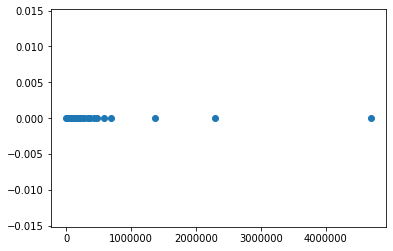

In [106]:
import matplotlib.pyplot as plt
%matplotlib inline
vector_values = list(cache.values())
y = [0 for i in vector_values]
plt.scatter(list(cache.values()), y)

## Conclusion
* So as we can see, there are three logs that are different from the rest of the logs.
* Since the minimum number of logs needed to form a cluster is 2, the three logs are either clustered with all the logs (1 cluster of 50 logs) or none of them are clustered together (all labelled as noise)
* Overall, it shows that the one dimension encoding is not able to capture the seperation between the logs.
* If we run testing on this current state, there will be two cases.
    * First, if we keep the original hardcoded hyperparameters, i.e., eps=0.3, min samples=3, we will get everything as noise and all the test cases will be predicted as noise. It would default to 0 which means it is not a flake. We have around 30% flakes in our dataset implying the accuracy of this model would be 70%. However, f1-score for the flake class would be 0. 
    * Second, if we modify the hyperparameters, everything will be one cluster. Since most points in this cluster will not be flakes, the cluster would be defined as non flakes. Again we get ~70% accuracy and 0 f1-score for flake class.
    
* In essence, the current method works well for very simple log messages but we will need to apply our data science workflow (EDA, research, POC) for real and complex logs. 